In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import math
from numpy import nan
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # ingore warnings

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
import matplotlib.pyplot as plt

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0354BD30>>
Traceback (most recent call last):
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [3]:
train_df["datetime"] = pd.to_datetime(train_df["timestamp"])
train_df["year"] = train_df["datetime"].dt.year
train_df["month"] = train_df["datetime"].dt.month
train_df["day"] = train_df["datetime"].dt.day
test_df["datetime"] = pd.to_datetime(test_df["timestamp"])
test_df["year"] = test_df["datetime"].dt.year
test_df["month"] = test_df["datetime"].dt.month
test_df["day"] = test_df["datetime"].dt.day

In [4]:
temp = train_df["build_year"].copy() 
temp[train_df["build_year"] < 1000] = train_df["year"][train_df["build_year"] < 1000] + train_df["build_year"][train_df["build_year"] < 1000]
temp2 = test_df["build_year"].copy() 
temp2[test_df["build_year"] < 1000] = test_df["year"][test_df["build_year"] < 1000] + test_df["build_year"][test_df["build_year"] < 1000]

In [5]:
train_df["build_year"] = temp
test_df["build_year"] = temp2

In [6]:
train_latlon = pd.read_csv("./train_lat_lon.csv")
test_latlon = pd.read_csv("./test_lat_lon.csv")

In [7]:
train_df = train_df.merge(train_latlon, on="id")
test_df = test_df.merge(test_latlon, on="id")

In [8]:
train_df.drop(['key', 'tolerance_m'], axis=1, inplace=True)
test_df.drop(['key', 'tolerance_m'], axis=1, inplace=True)

In [9]:
from com_util import *

In [10]:
train_df = merge_mean(train_df, ["sub_area"], ["build_year"], "new")
test_df = merge_mean(test_df, ["sub_area"], ["build_year"], "new")

In [11]:
train_df["new"] = round(train_df["new"])
test_df["new"] = round(test_df["new"])

In [12]:
train_df["build_year"] = train_df["build_year"].fillna(train_df["new"])
test_df["build_year"] = test_df["build_year"].fillna(test_df["new"])

In [13]:
train_df["build_age"] = train_df["year"] - train_df["build_year"]
test_df["build_age"] = test_df["year"] - test_df["build_year"]

In [14]:
train_df.drop(["new"], axis=1, inplace=True)
test_df.drop(["new"], axis=1, inplace=True)

In [15]:
train_df = train_df.replace({"no": -1, "yes": 1})
test_df = test_df.replace({"no": -1, "yes": 1})
inplace1 = (train_df["full_sq"] < train_df["life_sq"]) & (train_df["full_sq"] < 10)
temp3 = train_df["full_sq"].copy()
temp3[inplace1] = train_df["life_sq"][inplace1]
train_df["full_sq"] = temp3
inplace2 = train_df["life_sq"] < 2
temp4 = train_df["life_sq"].copy()
temp4[inplace2] = train_df["full_sq"][inplace2]
train_df["life_sq"] = temp4
inplace3 = (train_df["full_sq"] < train_df["life_sq"]) & (train_df["life_sq"] > 10)
temp5 = train_df["life_sq"].copy()
temp5[inplace3] = train_df["full_sq"][inplace3]
train_df["life_sq"] = temp5
inplace1 = (test_df["full_sq"] < test_df["life_sq"]) & (test_df["full_sq"] < 10)
temp3 = test_df["full_sq"].copy()
temp3[inplace1] = test_df["life_sq"][inplace1]
test_df["full_sq"] = temp3
inplace2 = test_df["life_sq"] < 2
temp4 = test_df["life_sq"].copy()
temp4[inplace2] = test_df["full_sq"][inplace2]
test_df["life_sq"] = temp4
inplace3 = (test_df["full_sq"] < test_df["life_sq"]) & (test_df["life_sq"] > 10)
temp5 = test_df["life_sq"].copy()
temp5[inplace3] = test_df["full_sq"][inplace3]
test_df["life_sq"] = temp5

In [16]:
train_df["floor_inverse"] = train_df["max_floor"] - train_df["floor"]
test_df["floor_inverse"] = test_df["max_floor"] - test_df["floor"]

In [17]:
train_df["floor_inverse"].ix[train_df["floor_inverse"] < 0] = nan
test_df["floor_inverse"].ix[test_df["floor_inverse"] < 0] = nan

C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
train_df["material"].ix[train_df["material"] == 33] = 3

C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
train_df = train_df.replace({"no": -1, "yes": 1})
test_df = test_df.replace({"no": -1, "yes": 1})
train_eco = pd.get_dummies(train_df["ecology"])
train_df = pd.concat([train_df, train_eco],axis=1)
test_eco = pd.get_dummies(test_df["ecology"])
test_df = pd.concat([test_df, test_eco],axis=1)
pt = pd.get_dummies(train_df["product_type"])
train_df = pd.concat([train_df, pt],axis=1)
pt = pd.get_dummies(test_df["product_type"])
test_df = pd.concat([test_df, pt],axis=1)
train_df.drop(['product_type'], axis=1, inplace=True)
test_df.drop(['product_type'], axis=1, inplace=True)
train_df.drop(['ecology'], axis=1, inplace=True)
test_df.drop(['ecology'], axis=1, inplace=True)

In [20]:
train_df["life_full"] = train_df["life_sq"] / train_df["full_sq"]
train_df["life_full"].ix[train_df["life_full"] > 1] = nan
test_df["life_full"] = test_df["life_sq"] / test_df["full_sq"]
test_df["life_full"].ix[test_df["life_full"] > 1] = nan

C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
y_train = train_df['price_doc'].values
id_test = test_df['id']
train_df.drop(['timestamp'], axis=1, inplace=True)
test_df.drop(['timestamp'], axis=1, inplace=True)
train_df.drop(['datetime'], axis=1, inplace=True)
test_df.drop(['datetime'], axis=1, inplace=True)

ValueError: labels ['datetime'] not contained in axis

In [4]:
train_df.drop("id", axis=1, inplace=True)
train_df.drop("price_doc", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)
train_df.drop("sub_area", axis=1, inplace=True)
test_df.drop("sub_area", axis=1, inplace=True)

In [7]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'silent': 1,
    'seed':0
}

dtrain = xgb.DMatrix(train_df, y_train)
dtest = xgb.DMatrix(test_df)

In [8]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= 480)

In [12]:
help(xgb.plot_importance)

Help on function plot_importance in module xgboost.plotting:

plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', grid=True, **kwargs)
    Plot importance based on fitted trees.
    
    Parameters
    ----------
    booster : Booster, XGBModel or dict
        Booster or XGBModel instance, or dict taken by Booster.get_fscore()
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    importance_type : str, default "weight"
        How the importance is calculated: either "weight", "gain", or "cover"
        "weight" is the number of times a feature appears in a tree
        "gain" is the average gain of splits which use the feature
        "cover" is the average coverage of splits which use the feature
            where coverage is defined as the number of samples affected by the split
    height : float, default 0.2
   

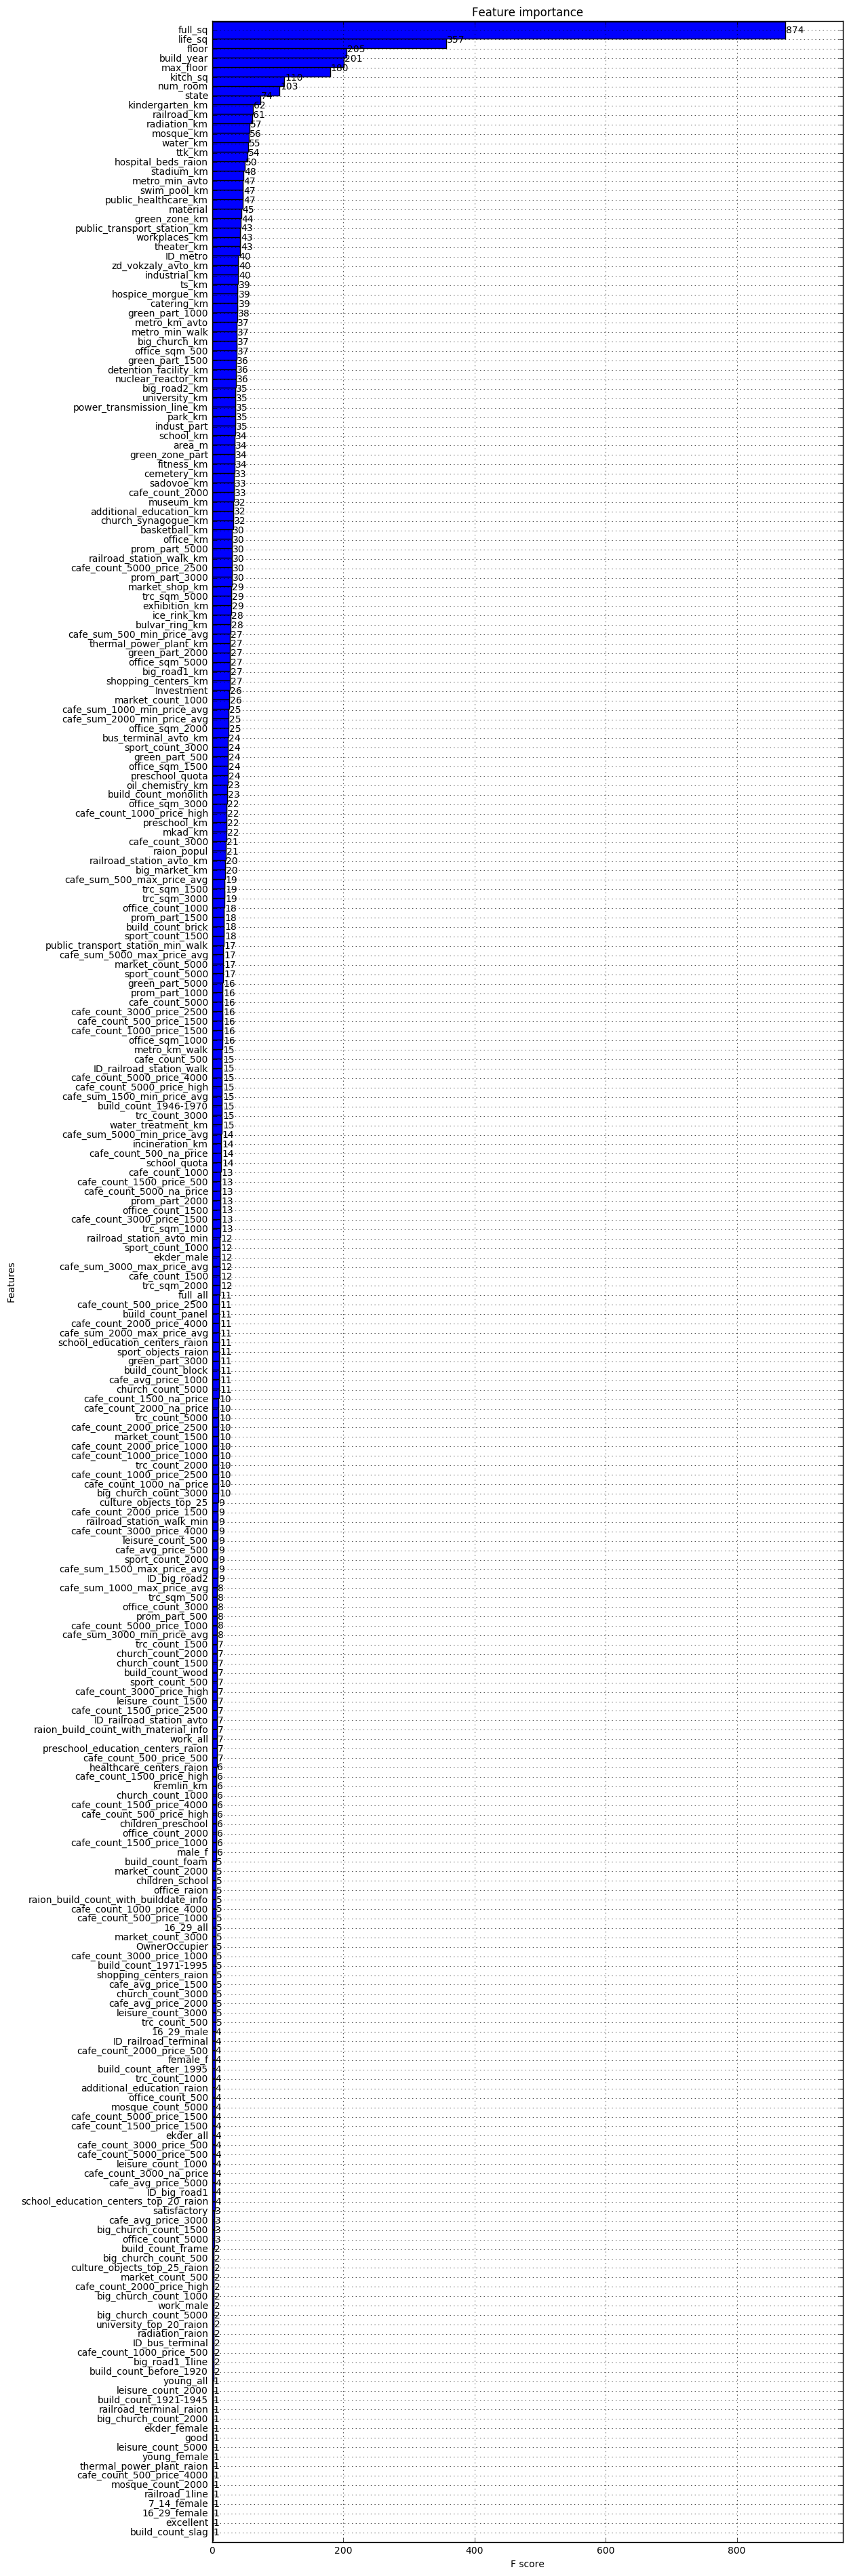

In [16]:
fig, ax = plt.subplots(figsize=(12,48))
xgb.plot_importance(model,height=1.8, ax=ax)
plt.show()

In [25]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})

In [26]:
output.head()

,id,price_doc
0,30474,6062056.5
1,30475,8330154.0
2,30476,5817519.5
3,30477,6089658.0
4,30478,5406075.5


In [27]:
output["price_doc"] = output["price_doc"] * 0.96

In [28]:
output.head()

,id,price_doc
0,30474,5819574.0
1,30475,7996947.5
2,30476,5584818.5
3,30477,5846071.5
4,30478,5189832.5


In [29]:
output.to_csv('NewStart1.csv', index=False)